## Load testing comparison for Nitro Enclaves ###

In [37]:
import requests
import time
import concurrent.futures
import base64
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def base64_encode(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def test_batch_request(encoded_images, url):
    start_time = time.time()
    response = requests.post(url, json={"images": encoded_images})
    elapsed_time = time.time() - start_time

    if response.status_code == 200:
        return elapsed_time, response.json()
    else:
        print(f"Request failed with status code: {response.status_code}")
        return None

def threaded_batch_test(encoded_images, url, num_threads, requests_per_thread):
   
    with concurrent.futures.ThreadPoolExecutor(max_workers = num_threads) as executor:
        futures = [executor.submit(test_batch_request, encoded_images, url) for _ in range(num_threads * requests_per_thread)]
        results = [f.result() for f in concurrent.futures.as_completed(futures)]
    
    results = [result for result in results if result is not None]
    return results

def run_threaded_batch_test(url, sample_image, batch_size, num_threads, requests_per_thread):

    encoded_image = base64_encode(sample_image)
    encoded_images = [encoded_image] * batch_size

    print(f"Using batch size of {batch_size} for each request")
    print(f"Starting batch test with {num_threads} threads and {requests_per_thread} requests per thread...")
    test_results = threaded_batch_test(encoded_images, url, num_threads, requests_per_thread)

    latencies = [result[0] for result in test_results]
    average_latency = sum(latencies) / len(latencies)
    print(f"Average latency: {average_latency:.4f} seconds")
    print(f"Min latency: {min(latencies):.4f} seconds")
    print(f"Max latency: {max(latencies):.4f} seconds")

In [18]:
def test_vary_thread_count(url, sample_image, batch_size, thread_counts, requests_per_thread):
    results = []

    for num_threads in thread_counts:
        
        print(f"Running test with {num_threads} threads...")
        encoded_image = base64_encode(sample_image)
        encoded_images = [encoded_image] * batch_size

        test_results = threaded_batch_test(encoded_images, url, num_threads, requests_per_thread)

        latencies = [result[0] for result in test_results]
        average_latency = sum(latencies) / len(latencies)
        min_latency = min(latencies)
        max_latency = max(latencies)

        results.append({
            "Threads": num_threads,
            "Average Latency": average_latency,
            "Min Latency": min_latency,
            "Max Latency": max_latency
        })
    return pd.DataFrame(results)

In [42]:
url = "http://18.223.112.165/predict/"
sample_image = "sample_images/sample_cat.jpeg"
batch_size = 1
thread_counts = [80, 90, 100, 150, 200]  
#thread_counts = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  
#thread_counts = [1, 10] 
requests_per_thread = 1 

enclave_result_df = test_vary_thread_count(url, sample_image, batch_size, thread_counts, requests_per_thread)
enclave_result_df

Running test with 80 threads...
Request failed with status code: 502
Running test with 90 threads...
Running test with 100 threads...
Running test with 150 threads...
Running test with 200 threads...


,Threads,Average Latency,Min Latency,Max Latency
0,80,7.872190,4.925628,10.339123
1,90,9.503820,5.060160,12.294043
2,100,10.741363,5.124124,13.796109
3,150,15.169948,8.618814,22.719595
4,200,19.286596,9.833476,25.649085


In [43]:
enclave_result_df.to_csv("enclave_batch1_req1_high_threads.csv", index=False)

In [ ]:
url = "http://18.223.112.165/predict/"
sample_image = "sample_images/sample_cat.jpeg"
batch_size = 1
thread_counts = [500, 1000, 2000]  
#thread_counts = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  
#thread_counts = [1, 10] 
requests_per_thread = 1 

public_result_df = test_vary_thread_count(url, sample_image, batch_size, thread_counts, requests_per_thread)
public_result_df

In [46]:
public_result_df.to_csv("public_batch1_req2_500-1000_threads.csv", index=False)

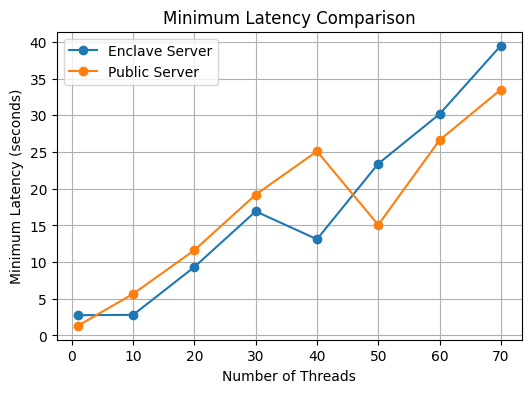

In [39]:
def plot_min_latencies(df1, df2, labels):

    min_latencies1 = df1['Min Latency']
    min_latencies2 = df2['Min Latency']
    threads = df1['Threads'] 

    plt.figure(figsize=(6, 4))
    plt.plot(threads, min_latencies1, marker='o', label=labels[0])  
    plt.plot(threads, min_latencies2, marker='o', label=labels[1]) 

    plt.xlabel('Number of Threads')
    plt.ylabel('Minimum Latency (seconds)')
    plt.title('Minimum Latency Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_min_latencies(enclave_result_df, public_result_df, labels=['Enclave Server', 'Public Server'])

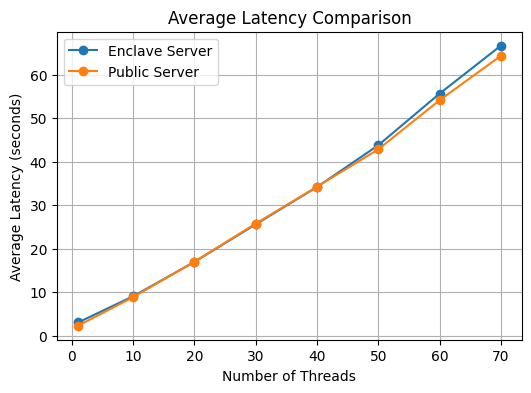

In [40]:
def plot_average_latencies(df1, df2, labels):
   
    avg_latencies1 = df1['Average Latency']
    avg_latencies2 = df2['Average Latency']
    threads = df1['Threads'] 

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.plot(threads, avg_latencies1, marker='o', label=labels[0])  
    plt.plot(threads, avg_latencies2, marker='o', label=labels[1])  

    plt.xlabel('Number of Threads')
    plt.ylabel('Average Latency (seconds)')
    plt.title('Average Latency Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_average_latencies(enclave_result_df, public_result_df, labels=['Enclave Server', 'Public Server'])

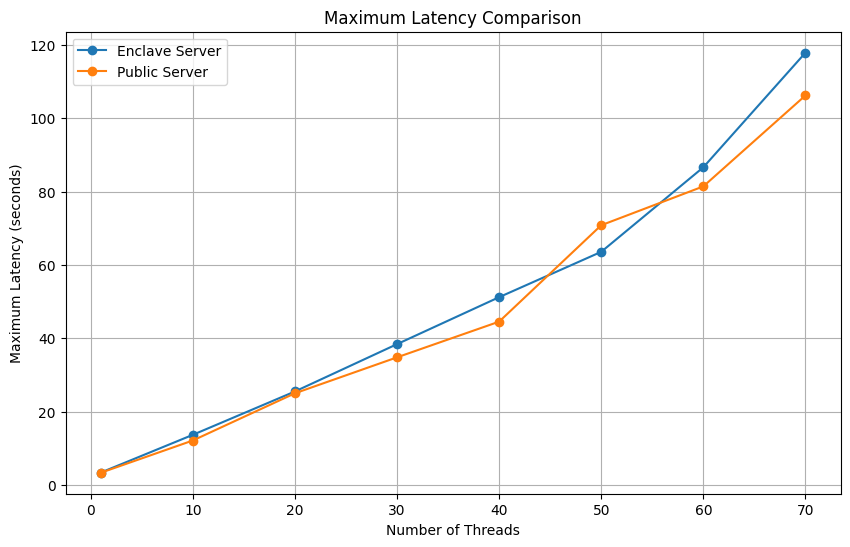

In [41]:
def plot_max_latencies(df1, df2, labels):
    
    max_latencies1 = df1['Max Latency']
    max_latencies2 = df2['Max Latency']
    threads = df1['Threads']

    plt.figure(figsize=(10, 6))
    plt.plot(threads, max_latencies1, marker='o', label=labels[0])  
    plt.plot(threads, max_latencies2, marker='o', label=labels[1]) 

    plt.xlabel('Number of Threads')
    plt.ylabel('Maximum Latency (seconds)')
    plt.title('Maximum Latency Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_max_latencies(enclave_result_df, public_result_df, labels=['Enclave Server', 'Public Server'])

### Test with concurrent requests from different threads ###

In [21]:
def threaded_batch_test(encoded_images, url, num_threads, requests_per_thread):
   
    with concurrent.futures.ThreadPoolExecutor(max_workers = num_threads) as executor:
        futures = [executor.submit(test_batch_request, encoded_images, url) for _ in range(num_threads * requests_per_thread)]
        results = [f.result() for f in concurrent.futures.as_completed(futures)]
    
    results = [result for result in results if result is not None]
    return results

def run_load_test_batch(url, sample_image, batch_size, num_threads, requests_per_thread):

    encoded_image = base64_encode(sample_image)
    encoded_images = [encoded_image] * batch_size

    print(f"Using batch size of {batch_size} for each request")
    print(f"Starting batch test with {num_threads} threads and {requests_per_thread} requests per thread...")
    test_results = threaded_batch_test(encoded_images, url, num_threads, requests_per_thread)

    latencies = [result[0] for result in test_results]
    average_latency = sum(latencies) / len(latencies)
    print(f"Average latency: {average_latency:.4f} seconds")
    print(f"Min latency: {min(latencies):.4f} seconds")
    print(f"Max latency: {max(latencies):.4f} seconds")

In [31]:
# Public 1
run_load_test_batch("http://18.223.112.165/predict/", "public/sample_images/sample_cat.jpeg", 5,50, 2)

Using batch size of 5 for each request
Starting batch test with 50 threads and 2 requests per thread...
Average latency: 21.9317 seconds
Min latency: 9.3324 seconds
Max latency: 35.6516 seconds


In [30]:
# Enclave 1
run_load_test_batch("http://18.223.112.165/predict/", "public/sample_images/sample_cat.jpeg", 5, 50,2)

Using batch size of 5 for each request
Starting batch test with 50 threads and 2 requests per thread...
Average latency: 57.8437 seconds
Min latency: 24.0395 seconds
Max latency: 106.5628 seconds
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status code: 502
Request failed with status 

In [33]:
# Public 2
run_load_test_batch("http://18.223.112.165/predict/", "public/sample_images/sample_cat.jpeg", 2,100,2)

Using batch size of 2 for each request
Starting batch test with 100 threads and 2 requests per thread...
Average latency: 19.9695 seconds
Min latency: 7.0691 seconds
Max latency: 41.7985 seconds


In [32]:
# Enclave 2
run_load_test_batch("http://18.223.112.165/predict/", "public/sample_images/sample_cat.jpeg", 2, 100,2)

Using batch size of 2 for each request
Starting batch test with 100 threads and 2 requests per thread...
Average latency: 20.9098 seconds
Min latency: 8.1304 seconds
Max latency: 58.0721 seconds
